In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from scipy.linalg import eig
import time
from copy import deepcopy

# TODO
* Generate Random Networks
    * ~~Fully connected network generation~~
    * ~~Aperiodic network generation~~
    * ~~Adjust probability of self link~~
    * ~~Ability to incrase wieghts of agents above bare minimum~~
        * Favour earlier agents when increasing degree
    * Growing instantly from an already existing network
    * Possibility of changing probability distribution of increased degree
    * Undirected networks
    * Non-uniform weights
    * More specific network structures
    * Non-cooperative agents
        * Through chance
        * Set amount, determined by network size/user input
        * Deviation from truth
    * Different probability distributions of initial belief
    
* Implement Updating Variations
    * Implement convergence
    * DeGroot
    * Private Belief
    * $\varepsilon$-DeGroot
    * Time-dependent weights

In [4]:
IMAGE_PATH = "ThesisKI/Images/"

In [11]:
class Network():
    def __init__(self, p_selflink=1, n_agents=1000):
        self.truth = random.uniform(0,1)
        self.p_selflink = p_selflink
        self.weights, self.beliefs = self.grow_network_instant(n_agents=n_agents)
        self.agent_degree_distribution(n_agents=1000, averaging_step=100, comparison=True, save_image=True)
        #self.speed_test(n_agents=n_agents, increase_degree=False)
        #self.degree_distribution(n_agents)
    
    def gen_t0(self):
        """
        Only for use with incremental growing.
        No longer necessary
        """
        # First agent always has a self link to ensure aperiodicity
        adjacency = np.ones((1,1))
        return adjacency
    
    def degree_distribution(self, n_agents, incremental=True, instant=True, 
                            save_image=False, save_path=IMAGE_PATH, show_plot=True):
        """
        Generates networks with n_agents to plot the degree distribution of said network.
        Compares the difference between the standard degree distribution and the degree
        distribution when additional links are generated for each network.
        
        Input:
            n_agents: int, number of agents the generated network will have.
            incremental: bool, default=True, whether the incremental generation 
                method should be used.
            instant: bool, default=True, whether the instant generation method 
                should be used.
            save_image: bool, default=False, whether the generated plots should
                be saved.
            save_path: string, default=IMAGE_PATH, the path to wich the images
                should be saved.
            show_plot: bool, default=True, whether the generated plots are shown.
        """
        if instant:
            # Generate a network with increased degree and with standard degree
            network_instant_increase, _ = self.grow_network_instant(n_agents=n_agents,
                                                                    increase_degree=True)
            network_instant, _ = self.grow_network_instant(n_agents=n_agents, increase_degree=False)

            # Compute the in- and out-degree of both networks
            instant_out_degree_increase = np.count_nonzero(network_instant_increase, axis=1)
            instant_in_degree_increase = np.count_nonzero(network_instant_increase, axis=0)
            instant_out_degree = np.count_nonzero(network_instant, axis=1)
            instant_in_degree = np.count_nonzero(network_instant, axis=0)
            
            # Generate the subplots for the histograms
            fig, axs = plt.subplots(2,2, sharey=True)
            fig.set_size_inches(7.5, 5)
            fig.suptitle(f"In- & Out-degree Distributions, Instant, n={n_agents}")
            # Number of bins is set to the max of the degree, s.t. each bin equals one
            axs[0, 0].hist(instant_out_degree, 
                           color="skyblue", bins=np.amax(instant_out_degree))
            axs[0, 0].set_title("Standard Out-egree")
            axs[0, 1].hist(instant_in_degree, 
                           color="skyblue", bins=np.amax(instant_in_degree))
            axs[0, 1].set_title("Standard In-degree")
            axs[1, 0].hist(instant_out_degree_increase, 
                           color="skyblue", bins=np.amax(instant_out_degree_increase))
            axs[1, 0].set_title("Increased Out-degree")
            axs[1, 1].hist(instant_in_degree_increase, 
                           color="skyblue", bins=np.amax(instant_in_degree_increase))
            axs[1, 1].set_title("Increased In-degree")

            fig.tight_layout()
            if save_image:
                plt.savefig(IMAGE_PATH+"InstantDegree.png")
            if show_plot:
                plt.show()
        
        if incremental:
            # Generate a network incrementally
            network = self.gen_t0()
            for i in range(n_agents):
                network = self.grow_network_concat(network)
                
            # Make a copy of the generated network to increase the degree
            network_increase = deepcopy(network)
            
            # Iterate over the agents
            for i in range(network.shape[0]):
                # Determine the additional in- and out-degree
                add_in_degree = int(np.floor(np.random.normal(2, 1)))
                add_out_degree = int(np.floor(np.random.normal(2, 1)))
                
                # Ensure only agents with a positive additional degree
                # will receive additional links
                if add_in_degree > 0:
                    for _ in range(add_in_degree):
                        j = np.random.randint(0, network.shape[0])
                        network_increase[j, i] = 1

                if add_in_degree > 0:
                    for _ in range(add_out_degree):
                        j = np.random.randint(0, network.shape[0])
                        network_increase[i, j] = 1                        

            # Compute the in- and out-degree of both networks
            incremental_out_degree_increase = np.count_nonzero(network_increase, axis=1)
            incremental_in_degree_increase = np.count_nonzero(network_increase, axis=0)
            incremental_out_degree = np.count_nonzero(network, axis=1)
            incremental_in_degree = np.count_nonzero(network, axis=0)
            
            # Generate the histogram subplots
            fig, axs = plt.subplots(2,2, sharey=True)
            fig.set_size_inches(7.5, 5)
            fig.suptitle(f"In- & Out-degree Distributions, Incremental, n={n_agents}")
            # Bins are set the to the max of the degree to ensure each bin equals one degree
            axs[0, 0].hist(instant_out_degree, 
                           color="coral", bins=np.amax(incremental_out_degree))
            axs[0, 0].set_title("Standard Out-degree")
            axs[0, 1].hist(incremental_in_degree, 
                           color="coral", bins=np.amax(incremental_in_degree))
            axs[0, 1].set_title("Standard In-degree")
            axs[1, 0].hist(incremental_out_degree_increase, 
                           color="coral", bins=np.amax(incremental_out_degree_increase))
            axs[1, 0].set_title("Increased Out-degree")
            axs[1, 1].hist(incremental_in_degree_increase, 
                           color="coral", bins=np.amax(incremental_in_degree_increase))
            axs[1, 1].set_title("Increased In-degree")
            
            fig.tight_layout()
            if save_image:
                plt.savefig(IMAGE_PATH+"IncrementalDegree.png")
            if show_plot:
                plt.show()
        
        if incremental and instant:
            
            # Generate the histogram subplots for the incremental and isntant degree
            # in a single group of subplots.
            fig, axs = plt.subplots(2,4, sharey=True)
            fig.set_size_inches(15, 10)
            # Bins are set to max of the degree so each bin equals one degree.
            fig.suptitle(f"In- & Out-degree Distributions (Instant vs. Incremental), n={n_agents}")
            axs[0, 0].hist(instant_out_degree, 
                           color="skyblue", bins=np.amax(instant_out_degree))
            axs[0, 0].set_title("Standard Degree")
            axs[0, 1].hist(instant_in_degree, 
                           color="skyblue", bins=np.amax(instant_in_degree))
            axs[0, 1].set_title("Standard Degree")
            axs[0, 2].hist(instant_out_degree_increase, 
                           color="skyblue", bins=np.amax(instant_out_degree_increase))
            axs[0, 2].set_title("Increased Degree")
            axs[0, 3].hist(instant_in_degree_increase, 
                           color="skyblue", bins=np.amax(instant_in_degree_increase))
            axs[0, 3].set_title("Increased Degree")

            axs[1, 0].hist(incremental_out_degree, 
                           color="coral", bins=np.amax(incremental_out_degree))
            axs[1, 0].set_title("Standard Degree")
            axs[1, 1].hist(incremental_in_degree, 
                           color="coral", bins=np.amax(incremental_in_degree))
            axs[1, 1].set_title("Standard Degree")
            axs[1, 2].hist(incremental_out_degree_increase, 
                           color="coral", bins=np.amax(incremental_out_degree_increase))
            axs[1, 2].set_title("Increased Degree")
            axs[1, 3].hist(incremental_in_degree_increase, 
                           color="coral", bins=np.amax(incremental_in_degree_increase))
            axs[1, 3].set_title("Increased Degree") 
            
            # Automatically generate the appropriate labels for the axes
            counter = 0
            for ax in axs.flat:
                if counter%2 == 0:
                    xlabel = "Out-degree"
                else:
                    xlabel = "In-degree"
                if counter < 4:
                    ylabel = "Instant"
                else:
                    ylabel = "Incremental"
                ax.set(xlabel=xlabel, ylabel=ylabel)
                counter+=1

            for ax in fig.get_axes():
                ax.label_outer()

            fig.tight_layout()
            if save_image:
                plt.savefig(IMAGE_PATH+"IncrementalVSInstantDegree.png")
            if show_plot:
                plt.show()
    
    def agent_degree_distribution(self, n_agents=30, increase_degree=True, 
                                  comparison=False, save_image=False, save_path=IMAGE_PATH,
                                  show_plot=True, averaging_step=1):
        
        x = [i+1 for i in range(int(n_agents/averaging_step))]
        avg = np.arange(n_agents)//averaging_step
        title = f"Degree Distribution, Per Agent, n={n_agents} \n 1 Bin Is Mean Of {averaging_step}"
        if not comparison:
            if increase_degree:
                title = "Standard " + title
                save_name = "IncreasedPerAgent.png"
            else:
                title = "Increased" + title
                save_name = "StandardPerAgent.png"
                
            network, _ = self.grow_network_instant(n_agents, increase_degree=increase_degree)
            
            out_degree = np.count_nonzero(network, axis=1)
            in_degree = np.count_nonzero(network, axis=0)
            
            out_degree_avg = np.bincount(avg, out_degree)/np.bincount(avg)
            in_degree_avg = np.bincount(avg, in_degree)/np.bincount(avg)
            
            fig, axs = plt.subplots(1, 2, sharey=True)
            fig.suptitle(title)
            axs[0].bar(x=x, height=out_degree_avg, color="skyblue")
            axs[0].set_title("Out-degree per agent")
            axs[1].bar(x=x, height=out_degree_avg, color="skyblue")
            axs[1].set_title("In-degree per agent")
            
            fig.tight_layout()
            counter = 0
            for ax in axs.flat:
                xlabel = "Agents"
                ylabel = "Degree"
                ax.set(xlabel=xlabel, ylabel=ylabel)
                counter+=1
            
        else:
            save_name = "ComparisonPerAgent"
            network, _ = self.grow_network_instant(n_agents, increase_degree=False)
            network_increase, _ = self.grow_network_instant(n_agents, increase_degree=True)
            
            out_degree_std = np.count_nonzero(network, axis=1)
            in_degree_std = np.count_nonzero(network, axis=0)
            
            out_degree_std_avg = np.bincount(avg, out_degree_std)/np.bincount(avg)
            in_degree_std_avg = np.bincount(avg, in_degree_std)/np.bincount(avg)
            
            out_degree_inc = np.count_nonzero(network_increase, axis=1)
            in_degree_inc = np.count_nonzero(network_increase, axis=0)
            
            out_degree_inc_avg = np.bincount(avg, out_degree_inc)/np.bincount(avg)
            in_degree_inc_avg = np.bincount(avg, in_degree_inc)/np.bincount(avg)            
            
            fig, axs = plt.subplots(2, 2, sharey=True)
            fig.suptitle(title)
            axs[0, 0].bar(x=x, height=out_degree_std_avg, color="skyblue")
            axs[0, 0].set_title("Standard Out-degree")
            axs[0, 1].bar(x=x, height=in_degree_std_avg, color="skyblue")
            axs[0, 1].set_title("Standard In-degree")
            
            axs[1, 0].bar(x=x, height=out_degree_inc_avg, color="coral")
            axs[1, 0].set_title("Increased Out-degree")
            axs[1, 1].bar(x=x, height=in_degree_inc_avg, color="coral")
            axs[1, 1].set_title("Increased In-degree")
            fig.tight_layout()
            counter = 0
            for ax in axs.flat:
                xlabel = "Agent"
                ax.set(xlabel=xlabel, ylabel="Degree")
                counter+=1
                
        for ax in fig.get_axes():
            ax.label_outer()

        if save_image:
            plt.savefig(IMAGE_PATH+save_name)
        if show_plot:
            plt.show()
    
    def speed_test(self, n_agents, save_image=False, save_path=IMAGE_PATH, 
                   show_plot=True, iterations=10, step_size=.1):
        """
        Compare the time to generate networks of up to n_agents using the 
        different generation methods, averaged over a given number of iterations.
        
        Input:
            n_agents: int, upper bound of network size.
            save_image: bool, default=False, whether the plot should be saved.
            save_path: string, default=IMAGE_PATH, the path to which the plot 
                should be saved.
            show_plot: bool, default=True, whether the plot should be shown.
            iterations: int, default=10, over how many iterations the time
                will be averaged.
            step_size: float, default=.1, used to indicate step size for generating
                the models, given by int(step_size*n_agents).
        """
        
        instant = []
        incremental = []
        for k in tqdm(range(iterations)):
            instant_time = []
            incremental_time = []
            sizes = []
            # Generate models of up to n_agents, increasing by step_size
            for i in range(0, n_agents+1, int(step_size*n_agents)):
                sizes.append(i)
                # Timing of instant generation of network
                t_start = time.perf_counter()
                network_instant, _ = self.grow_network_instant(n_agents=i)                
                t_end = time.perf_counter()
                # Compute passed time in ms
                instant_time.append((t_end-t_start)*1000)
                
                # Timing of incremental network generation
                t_start = time.perf_counter()
                network = self.gen_t0()
                for j in range(i):
                    network = self.grow_network_concat(network)
                t_end = time.perf_counter()
                # Compute passed time in ms
                incremental_time.append((t_end-t_start)*1000)
                
            instant.append(instant_time)
            incremental.append(incremental_time)            
        
        # Generate plots for the measurements
        plt.plot(sizes, np.mean(np.array(instant), axis=0), label="Instant", color="skyblue")
        plt.plot(sizes, np.mean(np.array(incremental), axis=0), label="Incremental", color="coral")
        plt.legend()
        plt.xlabel("Number of agents in network")
        plt.ylabel("Generation time (ms)")
        plt.title("Network generation time vs. agents")
        if save_image:
            plt.savefig(IMAGE_PATH+"GenTime2.png")
        if show_plot:
            plt.show()        
        
    def test_to_wisdom(self, n_agents):
        # Create network
        self.weights, self.beliefs = self.grow_network_instant(n_agents)
        convergence_times = []
        
        # Get time to converge for each n
        for i in range(n_agents):
            # Get stochastic matrix from weights matrix
            T = normalize_weights(self.weights[:i+1, :i+1])
            # Converge network and save the time
            t_to_convergence = self.converge_network(T)
            convergence_times.append(t_to_convergence)
            
            # Check if network is wise
            if (T@np.array(self.beliefs)[:i+1])[0] == self.truth:
                # Number of agents at which the network became wise
                return i+1, convergence_times
        else:
            # If the initial size of the network was not sufficient
            # to attain wisdom grow it incrementally until it does
            while (T@np.array(self.beliefs))[0] != self.truth:
                # Grow network, beliefs, and normalize the weights
                self.weights = self.grow_network_concat(self.weights)
                T = self.normalize_weights(self.weights)
                self.beliefs = self.grow_beliefs(self.beliefs)
                
                # Converge the network
                t_to_convergence = self.converge_network(T)
                convergence_times.append(t_to_convergence)
                
        return self.beliefs.shape[0]+1, converge_times
    
    def normalize_weights(self, weights):
        """
        Generates a stochastic adjacency matrix 
        based on the weight matrix.
        
        Input:
            weights: np.array, network weight matrix
        Output:
            stochastic weight matrix.
        """
        return weights/weights.sum(1)[:, np.newaxis]
    
    def grow_network_concat(self, weights):
        """
        Grows the existing network by 1 agent.
        Creates links between this agent and the existing agents in the network.
        
        Input:
            weights: square np.array, the network at its current size.
            p_selflink: float <=1, the probability that an agent forms
                a link with itself.
        Output:
            np.array, the inut network grown by one agent.        
        """
        
        # Grow network by one agent by concatenating a row and column of zeroes
        weights = np.concatenate((weights, np.zeros((1, weights.shape[1]))), axis=0)
        weights = np.concatenate((weights, np.zeros((weights.shape[0], 1))), axis=1)
        
        # Determine randomly if a self-link should be generated
        if random.uniform(0,1) <= self.p_selflink:
            weights[weights.shape[0]-1, weights.shape[1]-1] = 1
        
        # Create connections with the new agents in the network
        # Always at least one incoming and outgoing link, to guarantee strong connectedness
        out_agent = np.random.randint(weights.shape[0]-1)
        in_agent = np.random.randint(weights.shape[0]-1)        
        weights[weights.shape[0]-1, out_agent] = 1
        weights[in_agent, weights.shape[1]-1] = 1
        
        return weights
            
    def grow_network_instant(self, n_agents, increase_degree=False):
        """
        Creates a network of size n_agents x n_agents and makes the links.
        
        Input:
            n_agents: int, number of agents (and therefore dimensions) of the network
            increase_degree: bool, default=False, whether each agent should be generated
                with more than the minimum guaranteed links.
            p_selflink: float <=1, the probability that an agent forms a link with itself.
        Output:
            network: array, size n_agents x n_agents representing the network
        """
        
        weights = np.zeros((n_agents, n_agents))
        beliefs = []
        
        #for i in tqdm(range(n_agents)):
        for i in range(n_agents):
            # Ensure first agent receives a self loop to ensure aperiodicity
            if i == 0:
                weights[0,0] = 1
                continue
            else:
                # Determine which agents will recieve and send a link to agent i
                # Must have on of both to ensure full connectedness.
                # Chosen from the range of 
                in_link = np.random.randint(i)
                out_link = np.random.randint(i)

                # Check if there is not already an 
                # incoming link of this agent.
                if not weights[in_link, i]:
                    weights[in_link, i] = 1
                weights[i, out_link] = 1

                # Determine whether the agent has a self link
                if random.uniform(0,1) <= self.p_selflink:
                    weights[i,i] = 1
            
            # Increase the degree of the agent.
            if increase_degree:         
                # Determine the additional amount of links to 
                # be assigned to the agent.
                add_in_degree = int(np.floor(np.random.normal(2, 1)))
                add_out_degree = int(np.floor(np.random.normal(2, 1)))

                if add_in_degree > 0:
                    for _ in range(add_in_degree):
                        j = np.random.randint(0, n_agents)
                        weights[j, i] = 1
                if add_out_degree > 0: 
                    for _ in range(add_out_degree):
                        j = np.random.randint(0, n_agents)
                        weights[i, j] = 1
                        
            # Grow the belief vector to include the new agent
            beliefs = self.grow_beliefs(beliefs)
                
        return weights, beliefs
    
    def grow_beliefs(self, beliefs):
        signal = self.gen_signal()
        if signal < 0:
            beliefs.append(0)
        elif signal > 1:
            beliefs.append(1)
        else:
            beliefs.append(signal)
        return beliefs
    
    def gen_signal(self):
        """
        Generate the initial signal that an agent receives
        """
        return np.random.normal(self.truth, self.truth**2)
    
    def converge_network(self, T):
        """
        Converges the current network.
        Returns the amount of iterations required for convergence
        
        Output:
            counter: int, the step t at which the network converges
        """
        counter = 0
        prev_T = np.zeros(T.shape)
        while (prev_T - T).sum() != 0:
            prev_T = T
            T = T @ self.T
            counter+=1
        return counter-1

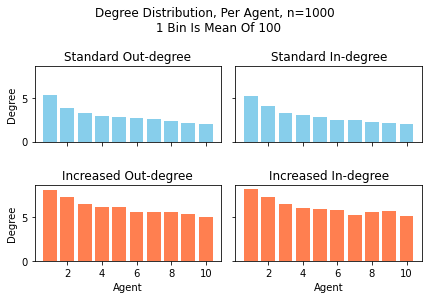

In [12]:
#plt.rcParams.update({'font.size': 10})
NetworkVar = Network()